<a href="https://colab.research.google.com/github/oodlbee/drug_prediction/blob/bob2708_branch/drug_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit

In [2]:
!pip install catboost

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

In [4]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Предобработка

## Уже обработанное

In [96]:
full = pd.read_csv("https://raw.githubusercontent.com/oodlbee/drug_prediction/master/processed_df.csv")
# full = pd.read_csv("https://raw.githubusercontent.com/oodlbee/drug_prediction/antons_branch/processed_df_without_corr.csv")
full.head(1)

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,#stars,...,SAfluorine,SAamideO,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,2.0,...,0.0,0.0,35.245,2.0,0.0,0.0,0.0,0.0,0.0,14.0


In [97]:
# processed_smiles = pd.DataFrame(columns=Descriptors.CalcMolDescriptors(Chem.MolFromSmiles(full['SMILES'][0])).keys())
# for i in range(full.shape[0]):
#     processed_smiles.loc[i] = Descriptors.CalcMolDescriptors(Chem.MolFromSmiles(full['SMILES'][i])).values()

In [98]:
def mol_dsc_calc(mols):
    return pd.DataFrame({k: f(Chem.MolFromSmiles(m)) for k, f in descriptors.items()} for m in mols)

# список конституционных и физико-химических дескрипторов из библиотеки RDKit
descriptors = {"HeavyAtomCount": Descriptors.HeavyAtomCount,
               "NHOHCount": Descriptors.NHOHCount,
               "NOCount": Descriptors.NOCount,
               "NumHAcceptors": Descriptors.NumHAcceptors,
               "NumHDonors": Descriptors.NumHDonors,
               "NumHeteroatoms": Descriptors.NumHeteroatoms,
               "NumRotatableBonds": Descriptors.NumRotatableBonds,
               "NumValenceElectrons": Descriptors.NumValenceElectrons,
               "NumAromaticRings": Descriptors.NumAromaticRings,
               "NumAliphaticHeterocycles": Descriptors.NumAliphaticHeterocycles,
               "RingCount": Descriptors.RingCount,
               "MW": Descriptors.MolWt,
               "LogP": Descriptors.MolLogP,
               "MR": Descriptors.MolMR,
               "TPSA": Descriptors.TPSA}

# sklearn трансформер для использования в конвейерном моделировании
descriptors_transformer = FunctionTransformer(mol_dsc_calc)
processed_smiles = descriptors_transformer.transform(full['SMILES'])
processed_smiles

[21:27:13] Conflicting single bond directions around double bond at index 55.
[21:27:13]   BondStereo set to STEREONONE and single bond directions set to NONE.
[21:27:13] Conflicting single bond directions around double bond at index 55.
[21:27:13]   BondStereo set to STEREONONE and single bond directions set to NONE.
[21:27:13] Conflicting single bond directions around double bond at index 55.
[21:27:13]   BondStereo set to STEREONONE and single bond directions set to NONE.
[21:27:13] Conflicting single bond directions around double bond at index 55.
[21:27:13]   BondStereo set to STEREONONE and single bond directions set to NONE.
[21:27:13] Conflicting single bond directions around double bond at index 55.
[21:27:13]   BondStereo set to STEREONONE and single bond directions set to NONE.
[21:27:13] Conflicting single bond directions around double bond at index 55.
[21:27:13]   BondStereo set to STEREONONE and single bond directions set to NONE.
[21:27:13] Conflicting single bond direc

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,MW,LogP,MR,TPSA
0,14,1,2,2,1,2,2,80,0,0,2,195.306,2.26590,58.6168,32.59
1,18,0,2,2,0,2,5,104,0,0,2,250.430,3.61540,79.3190,15.60
2,16,0,2,2,0,2,3,92,0,0,2,222.376,2.83520,70.0850,15.60
3,17,0,3,3,0,3,3,98,0,0,2,239.359,2.30600,67.6630,29.54
4,41,0,4,2,0,4,16,236,0,0,4,570.995,8.44430,179.0658,24.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,18,0,3,3,0,3,7,102,1,0,1,252.354,3.71572,73.2770,39.44
1313,17,1,3,3,1,3,6,96,1,0,1,238.327,3.41272,68.3898,50.44
1314,17,0,3,3,0,3,6,96,1,0,1,238.327,3.32562,68.6600,39.44
1315,16,0,3,3,0,3,5,90,1,0,1,224.300,2.93552,64.0430,39.44


In [99]:
full.drop(["Title","SMILES"], axis=1, inplace=True)
full = full.join(processed_smiles)
full.dropna(inplace=True) # for all descriptors work
X = full.iloc[:, 3:]
y = full.iloc[:, :3]
y_si = y["SI"]
y_ic = y["IC50, mmg/ml"]
y_cc = y["CC50-MDCK, mmg/ml"]
X_train, X_test, y_train, y_test = train_test_split(X, y_cc,  test_size=0.25, random_state=42)

In [109]:
X.describe()

,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,#stars,#amine,#amidine,#acid,#amide,#rotor,...,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,MW,LogP,MR,TPSA
count,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,...,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000,1317.000000
mean,386.250026,3.887623,1.334852,83.045239,1.662111,0.186029,0.028853,0.134396,0.138193,5.482916,...,6.301443,4.385725,145.489749,1.976462,0.747153,3.787396,386.247374,3.750206,105.025026,75.654715
std,148.239825,2.787751,1.769234,53.121625,2.936594,0.449098,0.167458,0.394887,0.402168,5.015543,...,3.532236,3.295946,56.769097,1.533385,0.948844,1.560451,148.238352,1.916895,39.403484,51.912926
min,110.157000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,42.000000,0.000000,0.000000,0.000000,110.156000,-3.575830,28.088500,0.000000
25%,289.468000,2.000000,0.000000,41.570000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,4.000000,2.000000,110.000000,1.000000,0.000000,3.000000,289.467000,2.727100,78.386700,39.440000
50%,352.450000,3.000000,1.000000,73.560000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,...,6.000000,4.000000,130.000000,2.000000,0.000000,4.000000,352.446000,3.673500,95.457800,65.100000
75%,446.535000,5.000000,2.000000,106.630000,2.000000,0.000000,0.000000,0.000000,0.000000,7.000000,...,8.000000,6.000000,162.000000,3.000000,1.000000,5.000000,446.536000,4.856500,121.040500,94.640000
max,1159.380000,19.000000,11.000000,319.510000,17.000000,4.000000,1.000000,2.000000,4.000000,35.000000,...,21.000000,30.000000,460.000000,7.000000,4.000000,10.000000,1159.370000,12.822200,290.422100,319.510000


## Первый лист 1400

In [24]:
# df_1400 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1400.xlsx')
# df_1400.head()

In [25]:
# df_1400.describe()

In [26]:
# df_1400_easy = df_1400.drop(["Title", "Pictures", "SMILES"], axis=1)
# df_1400_easy['SI'] = df_1400_easy['CC50-MDCK, mmg/ml']/df_1400_easy['IC50, mmg/ml']
# df_1400_easy.info()

In [27]:
# X = df_1400_easy.iloc[:, 3:]
# y = df_1400_easy.iloc[:, :3]
# X

In [28]:
# # Варианты целевой колонки
# y_si = y["SI"]
# y_ic = y["IC50, mmg/ml"]
# y_cc = y["CC50-MDCK, mmg/ml"]

In [29]:
# # Не забываем заменить агрумент 'y' при выборе другого целевого столбца
# X_train, X_test, y_train, y_test = train_test_split(X, y_ic,  test_size=0.25, random_state=42)

## Второй лист 1400

In [30]:
# df_1400_big = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1400.xlsx', 1)
# df_1400_big.info()

In [31]:
# df_1400_big = df_1400_big.drop(['molecule', 'Pictures', 'SMILES', 'Unnamed: 55', 'Unnamed: 56'], axis=1)
# df_1400_big.dropna(inplace=True)

In [32]:
# X = df_1400_big.iloc[:, 3:]
# y = df_1400_big.iloc[:, :3]
# y_si = y["SI"]
# y_ic = y["IC50, mmg/ml"]
# y_cc = y["CC50-MDCK, mmg/ml"]

In [33]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_cc,  test_size=0.25, random_state=42)

# Запуск моделей

## Линейная регрессия

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.433e+06, tolerance: 1.699e+03
  model = cd_fast.enet_coordinate_descent(


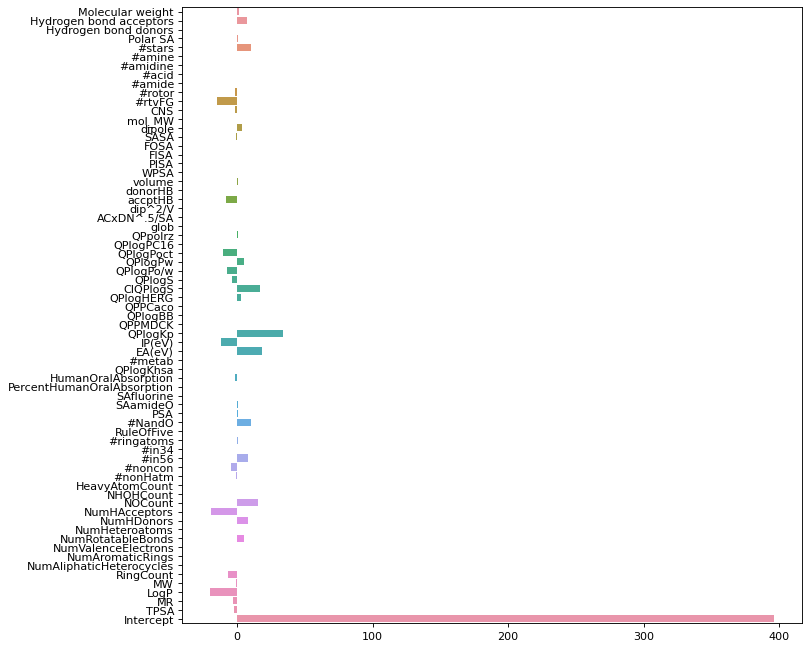

In [116]:
lasso = LassoCV(alphas = np.linspace(10, 25, 100), cv = 4, random_state = 13).fit(X_train, y_train)
plt.figure(figsize=(10, 10), dpi=80)
coefs = np.append(lasso.coef_, lasso.intercept_)
names = list(X_train.columns)
names.append('Intercept')
g = sns.barplot(y=names, x=coefs)#, columns=X_train.columns)
plt.show()

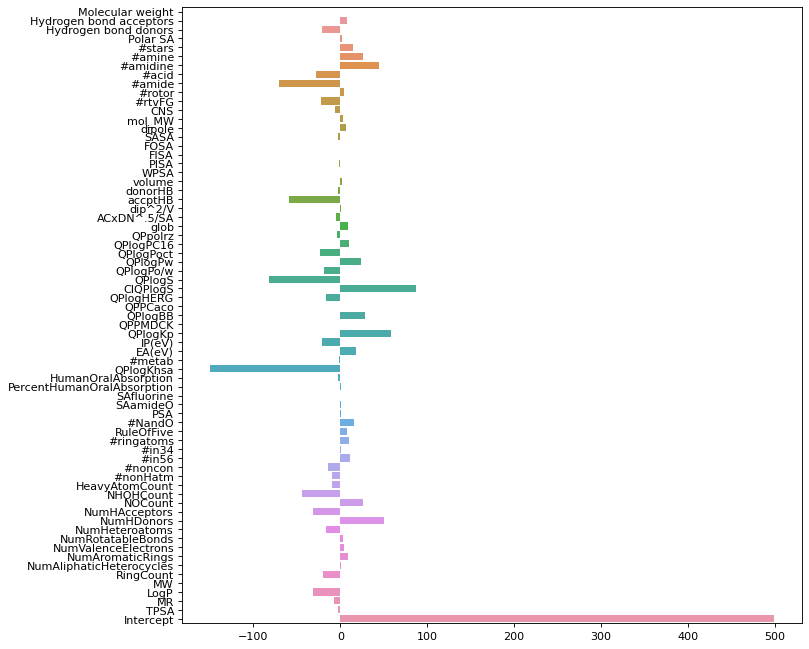

In [117]:
ridge = RidgeCV(alphas = np.linspace(10, 25, 100), cv = 4).fit(X_train, y_train)
plt.figure(figsize=(10, 10), dpi=80)
coefs = np.append(ridge.coef_, ridge.intercept_)
names = list(X_train.columns)
names.append('Intercept')
g = sns.barplot(y=names, x=coefs)#, columns=X_train.columns)
plt.show()

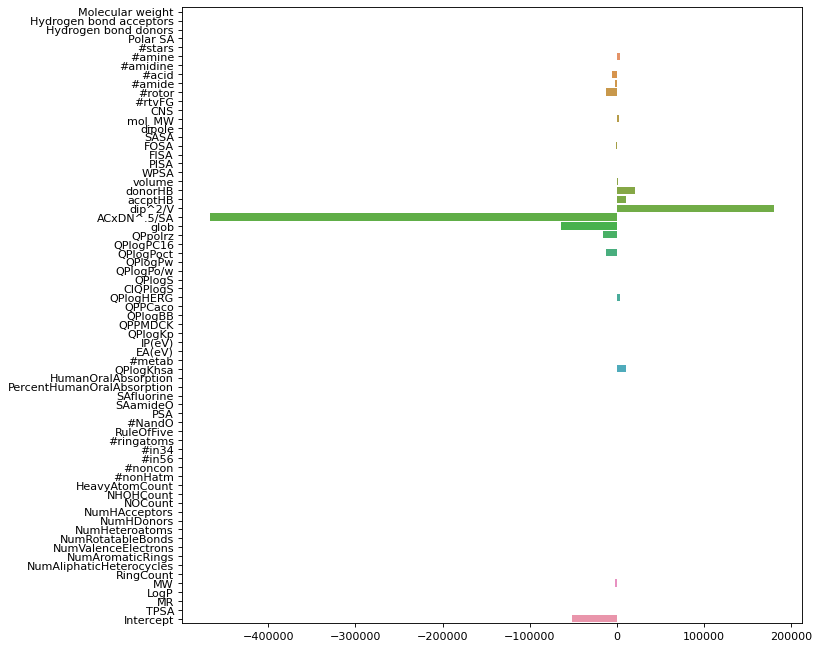

In [118]:
lr = LinearRegression().fit(X_train, y_train)
plt.figure(figsize=(10, 10), dpi=80)
coefs = np.append(lr.coef_, lr.intercept_)
names = list(X_train.columns)
names.append('Intercept')
g = sns.barplot(y=names, x=coefs)#, columns=X_train.columns)
plt.show()

## SVR

In [84]:
# line_param = np.linspace(0, 20, 20)
# parameters = {'kernel':('rbf', "poly", "sigmoid"), 'C':line_param}
# svr = make_pipeline(StandardScaler(), SVR())
# grid_search_svm = GridSearchCV(estimator=svr, param_grid=parameters, cv = 6)
# grid_search_svm.fit(X_train, y_train)
# svr = grid_search_svm.best_estimator_
svr = SVR().fit(X_train, y_train)
# svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
# svr.fit(X, y)

## Деревья (лес)

In [85]:
rf = RandomForestRegressor().fit(X_train, y_train)
# rf.score(X_test, y_test)

## Деревья (Бустинг)

In [86]:
# ada = AdaBoostRegressor().fit(X_train, y_train)
cat = CatBoostRegressor(4000).fit(X_train, y_train, early_stopping_rounds=10)

Learning rate set to 0.013238
0:	learn: 130.8026227	total: 14.3ms	remaining: 57.3s
1:	learn: 130.3907741	total: 27ms	remaining: 54s
2:	learn: 129.9076931	total: 42.4ms	remaining: 56.5s
3:	learn: 129.4710466	total: 58.9ms	remaining: 58.8s
4:	learn: 129.0094975	total: 80.8ms	remaining: 1m 4s
5:	learn: 128.6206369	total: 102ms	remaining: 1m 7s
6:	learn: 128.2010498	total: 120ms	remaining: 1m 8s
7:	learn: 127.7693438	total: 139ms	remaining: 1m 9s
8:	learn: 127.3535944	total: 155ms	remaining: 1m 8s
9:	learn: 126.9692303	total: 179ms	remaining: 1m 11s
10:	learn: 126.5870550	total: 204ms	remaining: 1m 13s
11:	learn: 126.2337994	total: 227ms	remaining: 1m 15s
12:	learn: 125.8166594	total: 249ms	remaining: 1m 16s
13:	learn: 125.4085718	total: 267ms	remaining: 1m 16s
14:	learn: 125.0188930	total: 301ms	remaining: 1m 19s
15:	learn: 124.6771386	total: 323ms	remaining: 1m 20s
16:	learn: 124.3351500	total: 344ms	remaining: 1m 20s
17:	learn: 123.9772247	total: 363ms	remaining: 1m 20s
18:	learn: 123.6

# Оценка моделей

In [119]:
def calc_metrics(model, X_test=X_test, y_test=y_test, df=None):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    r2 = model.score(X_test, y_test)
    pred_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, pred_train)
    r2_train = model.score(X_train, y_train)
    if df is not None:
        df.loc[str(model)] = [mae_train, mae, r2_train, r2]
    else:
        print(f"R-score: {r2}\nMAE: {mae}")

In [120]:
models = [lr, ridge, lasso, svr, rf,  cat]
metrics = pd.DataFrame(columns=('MAE train', 'MAE test', 'R2 train', 'R2 test'))
for model in models:
    calc_metrics(model, df=metrics)
metrics

,MAE train,MAE test,R2 train,R2 test
LinearRegression(),78.461893,83.831885,0.420086,0.195539
Ridge(),79.062520,82.894451,0.415305,0.234005
Lasso(),81.701579,82.290920,0.378894,0.265551
SVR(),101.625947,98.303556,-0.054707,-0.066208
RandomForestRegressor(),26.427381,68.710813,0.921903,0.407229
<catboost.core.CatBoostRegressor object at 0x7994e6173220>,14.246357,64.432464,0.978234,0.427961


In [89]:
opa = pd.DataFrame({"Predicted": cat.predict(X_test), "True": y_test})
opa.describe()

,Predicted,True
count,330.000000,330.000000
mean,140.370584,130.648788
std,93.037353,122.894382
min,-6.132925,0.100000
25%,62.947689,30.425000
50%,113.759126,80.400000
75%,217.616957,300.000000
max,415.739868,500.000000


In [94]:
si = opa2/opa
# mean_absolute_error(si.iloc[:, 0], si.iloc[:, 1])
mean_absolute_error(opa.iloc[:, 0], opa.iloc[:, 1])


46.68310240904196